# Handout #4: Unsupervised Learning (hierarchical clustering)

In [1]:
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score

In [2]:
group = '03' # assuming group 1
ds = 5 # assuming problems 5
data = np.loadtxt(f'ds{group}{str(ds)}.txt')
X = data[:, 0:2]
y = data[:, 2]

## Pintado de datos con etiquetas originales 

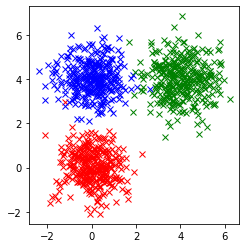

In [3]:
def draw_dataset(data):
    plt.subplot(111,aspect=1)
    w_0 = data[data[:,2] == 0]
    w_1 = data[data[:,2] == 1]
    w_2 = data[data[:,2] == 2]
    plt.plot(w_0[:,0], w_0[:,1], 'rx')
    plt.plot(w_1[:,0], w_1[:,1], 'bx');
    plt.plot(w_2[:,0], w_2[:,1], 'gx');
    
draw_dataset(data)

## Soluciones

**P5. Given the dataset dsxx5.txt, cluster it according to the following combinations:**
- **the complete linkage, the average linkage and the ward algorithms,**
- **2, 3, 4, and 5 clusters, and**
- **the Euclidean distance**

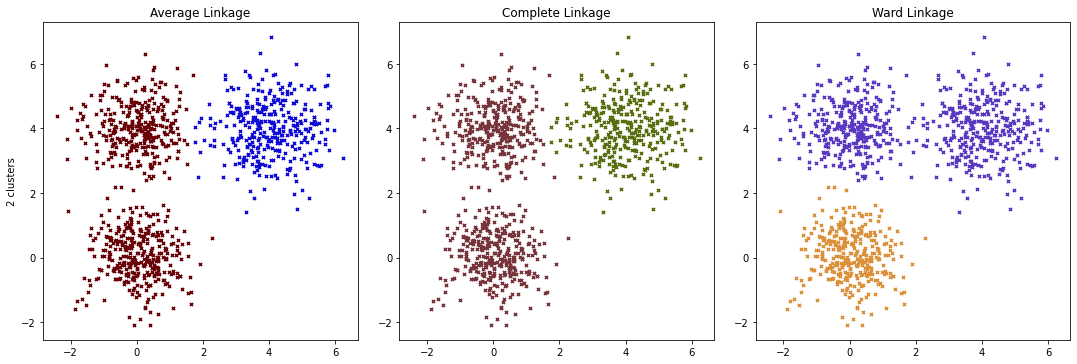

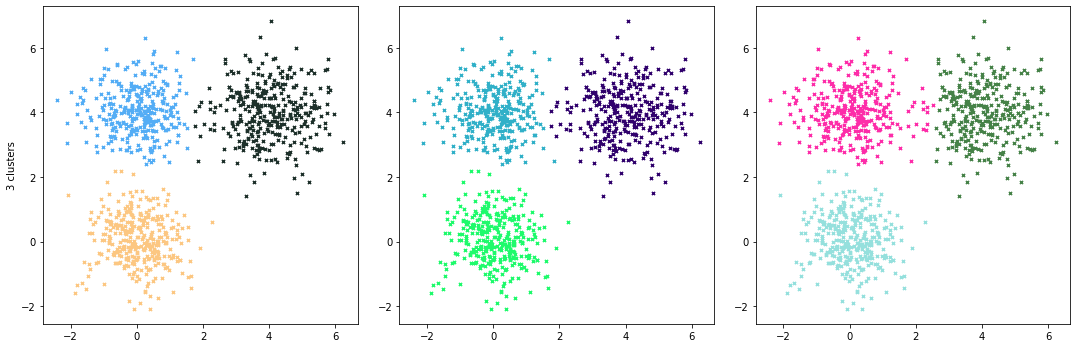

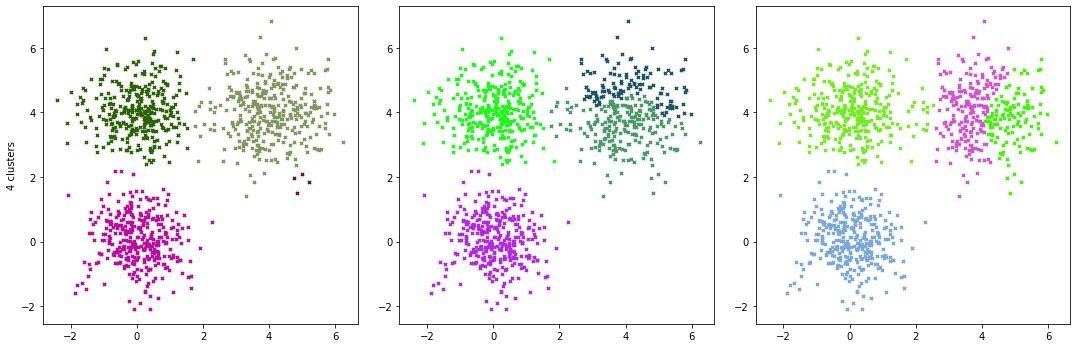

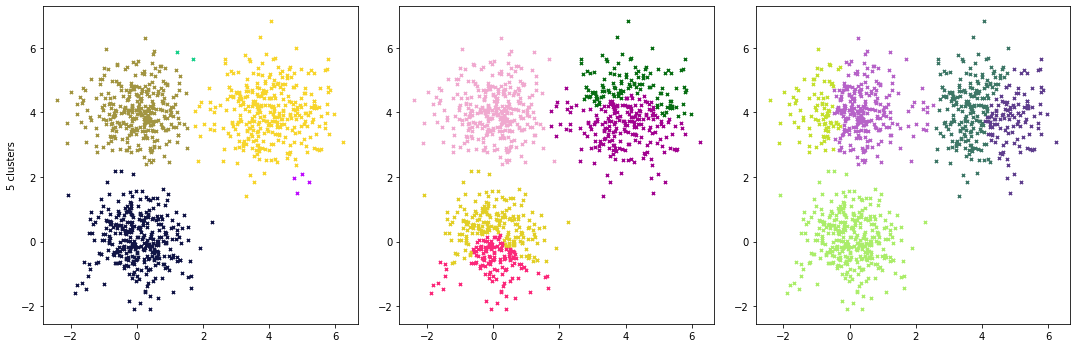

In [4]:
number_of_cluster_list = [2, 3, 4, 5]

# Almacenaremos los modelos en este diccionario para su posterior uso en los diferentes apartados
clustering_models_by_n = {}

i = 0

for n_clusters in number_of_cluster_list:
    # Inicialización de los modelos de clustering
    complete = cluster.AgglomerativeClustering(
        n_clusters = n_clusters, linkage = "complete"
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters = n_clusters, linkage = "ward"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters = n_clusters, linkage = "average"
    )

    clustering_algorithms = (
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward)
    )
    
    # Guardamos los modelos
    clustering_models_by_n[n_clusters] = clustering_algorithms
    
    f, axs = plt.subplots(1, len(clustering_algorithms), figsize = (15, 5))
    f.tight_layout()
    
    j = 0

    for name, model in clustering_algorithms:
        model.fit(X)
        labels = model.labels_   
        distinct_labels = list(set(labels))
    
        # Pintamos el resultado, mostrando una fila por nº de clusters y una columna por algoritmo
        for label in distinct_labels:
            if i == 0:
                axs[j].set_title(name)
            
            if j == 0:
                axs[j].set(ylabel = str(n_clusters) + ' clusters')
                
            axs[j].scatter(X[labels == label, 0], X[labels == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
            
        j = j + 1
    i = i + 1

**(a) considering the V-measure (external measure):**

**i) calculate the metric value for all cases**

In [5]:
# Iteramos sobre los modelos almacenados anteriormente en el diccionario clustering_models_by_n
for n_clusters, clustering_algorithms in clustering_models_by_n.items():
    print(f'{str(n_clusters)} clusters:')
    for name, model in clustering_algorithms:    
        v_score = v_measure_score(y, model.labels_)
        print(f'\t{name}: {str(v_score)}')

    print()

2 clusters:
	Average Linkage: 0.697801838383488
	Complete Linkage: 0.6910551181515815
	Ward Linkage: 0.7074689759955484

3 clusters:
	Average Linkage: 0.9483994093801745
	Complete Linkage: 0.9434811694463879
	Ward Linkage: 0.9218729853888192

4 clusters:
	Average Linkage: 0.939173567899995
	Complete Linkage: 0.8594437707892165
	Ward Linkage: 0.8408965773668715

5 clusters:
	Average Linkage: 0.9388886095068957
	Complete Linkage: 0.7868174054169651
	Ward Linkage: 0.7818896400244894



**ii) select the best number of clusters according to this metric for each algorithm**

In [6]:
# Cuanto más alto es el valor del V measure, más homogeneos y completos serán los clusters
# (recordemos que es la media harmónica entre las medidas de completitud y homogeneidad)

# Creamos un diccionario cuya key será el modelo y su valor una tupla con el
# número de clusters más óptimo y su v_score
best_n_clusters_by_model = {}

for n_clusters, clustering_algorithms in clustering_models_by_n.items():
    for name, model in clustering_algorithms:    
        v_score = v_measure_score(y, model.labels_)
        
        if name not in best_n_clusters_by_model:
            # Inicializamos el diccionario
            best_n_clusters_by_model[name] = (n_clusters, v_score) 
        else:
            # Si es mejor candidato, lo añadimos al diccionario
            if best_n_clusters_by_model[name][1] < v_score:
                best_n_clusters_by_model[name] = (n_clusters, v_score)
                
# Mostramos el resultado
for name, tuple in best_n_clusters_by_model.items():
    print(f'{name}: {tuple[0]} clusters (score = {tuple[1]})')

Average Linkage: 3 clusters (score = 0.9483994093801745)
Complete Linkage: 3 clusters (score = 0.9434811694463879)
Ward Linkage: 3 clusters (score = 0.9218729853888192)


**iii) select the best algorithm and number of clusters according to this metric**

In [7]:
# Partimos del resultado del apartado anterior
best_result = ()

for name, tuple in best_n_clusters_by_model.items():
    if not best_result:
        # Si aún no tenemos candidato, añadimos el actual
        best_result = (name, tuple[0], tuple[1])
    else:
        if best_result[2] < tuple[1]:
            # Si el resultado es menor (más óptimo) lo guardamos en best_result
            best_result = (name, tuple[0], tuple[1])
            
optimal_algorithm_name = best_result[0]
optimal_n_clusters = best_result[1]
optimal_v_score = best_result[2]

print(f"El mejor algoritmo es {optimal_algorithm_name}, con {optimal_n_clusters} clusters y una puntuación de {optimal_v_score}")

El mejor algoritmo es Average Linkage, con 3 clusters y una puntuación de 0.9483994093801745


**iv) plot separately the dataset using the true labelling and the labelling derived from the best algorithm
and number of clusters**

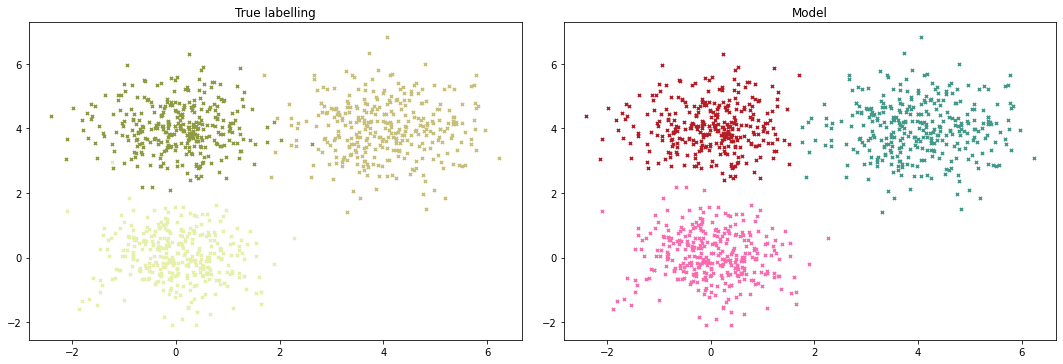

In [8]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
f.tight_layout()

# Recuperamos el modelo que corresponde al mejor resultado
optimal_model = clustering_models_by_n[optimal_n_clusters][[0] == optimal_algorithm_name][1]
optimal_labels = optimal_model.labels_
distinct_labels = list(set(y))

for label in distinct_labels:
    # Etiquetas reales
    axs[0].scatter(X[y == label, 0], X[y == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
    axs[0].set_title("True labelling")

    # Etiquetas provenientes del modelo
    axs[1].scatter(X[optimal_labels == label, 0], X[optimal_labels == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
    axs[1].set_title("Model")

**v) find the contingency table for the best algorithm and number of clusters, and**

In [9]:
contingency_matrix(y, optimal_labels)

array([[  0,   1, 333],
       [  5, 325,   3],
       [332,   1,   0]])

**vi) determine the asignment of classes to clusters and the number of clustering errors that result from the
best algorithm and number of clusters;**

La matriz de contingencia nos muestra las clases reales por fila y los clusters por columna. En el resultado de clustering más óptimo coincide el número de clases con el número de clusters, lo que es buena señal. En la matriz podemos observar que la clase 1 ha sido asignada mayoritariamente al cluster 3, la clase 2 al cluster 2 y la clase 3 al cluster 1.

In [10]:
# Homogeneidad
print(f"Homogeneidad: {homogeneity_score(y, optimal_labels)}")
# Completitud
print(f"Completitud: {completeness_score(y, optimal_labels)}")

Homogeneidad: 0.9483604399493534
Completitud: 0.948438382013742


La homogeneidad indica cómo de homogeneos son los clusters, es decir, el número de clases reales que abarca. El resultado es muy cercano a 1, lo que indica que los clusters no mezclan clases dentro de ellos

La completitud indica cómo de repartida ha sido una clase entre los diferentes clusters. Cuanto más contenida en un único cluster esté cada clase, mayor completitud obtendremos. En este caso el resultado es cercano a 1, lo que indica que las clases están bien definidas en los clusters creados.

En cuanto a los errores de asignación, podemos observar que:

la clase 1 tiene 1 error de asignación
la clase 2 tiene 8 errores de asignación
la clase 3 tiene 1 error de asignación

**(b) considering the Davies-Bouldin score (internal measure):**

**i) calculate the metric value for all cases**

In [11]:
# Iteramos sobre los modelos almacenados anteriormente en el diccionario clustering_models_by_n
for n_clusters, clustering_algorithms in clustering_models_by_n.items():
    print(f'{str(n_clusters)} clusters:')
    for name, model in clustering_algorithms:    
        db_index = davies_bouldin_score(X, model.labels_)
        print(f'\t{name}: {str(db_index)}')

    print()

2 clusters:
	Average Linkage: 0.7306341641931422
	Complete Linkage: 0.7287233755427889
	Ward Linkage: 0.6994859151992896

3 clusters:
	Average Linkage: 0.49371549280209454
	Complete Linkage: 0.49410943025153825
	Ward Linkage: 0.5004619778254527

4 clusters:
	Average Linkage: 0.5315080500782563
	Complete Linkage: 0.9439331074877508
	Ward Linkage: 0.8693074985215412

5 clusters:
	Average Linkage: 0.530908302241958
	Complete Linkage: 1.2241723912358822
	Ward Linkage: 1.0197768095902002



**ii) select the best number of clusters according to this metric for each algorithm**

In [12]:
# Cuanto más bajo es el valor del índice de Davies Bouldin, más compactos serán los 
# clusters y más separados entre sí, por lo tanto cogeremos el valor más pequeño

# Creamos un diccionario cuya key será el modelo y su valor una tupla con el
# número de clusters más óptimo y su db_index
best_n_clusters_by_model = {}

for n_clusters, clustering_algorithms in clustering_models_by_n.items():
    for name, model in clustering_algorithms:    
        db_index = davies_bouldin_score(X, model.labels_)
        
        if name not in best_n_clusters_by_model:
            # Inicializamos el diccionario
            best_n_clusters_by_model[name] = (n_clusters, db_index) 
        else:
            # Si es mejor candidato, lo añadimos al diccionario
            if best_n_clusters_by_model[name][1] > db_index:
                best_n_clusters_by_model[name] = (n_clusters, db_index)
                
# Mostramos el resultado
for name, tuple in best_n_clusters_by_model.items():
    print(f'{name}: {tuple[0]} clusters (score = {tuple[1]})')

Average Linkage: 3 clusters (score = 0.49371549280209454)
Complete Linkage: 3 clusters (score = 0.49410943025153825)
Ward Linkage: 3 clusters (score = 0.5004619778254527)


**iii) select the best algorithm and number of clusters according to this metric**

In [13]:
# Partimos del resultado del apartado anterior
best_result = ()

for name, tuple in best_n_clusters_by_model.items():
    if not best_result:
        # Si aún no tenemos candidato, añadimos el actual
        best_result = (name, tuple[0], tuple[1])
    else:
        if best_result[2] > tuple[1]:
            # Si el resultado es menor (más óptimo) lo guardamos en best_result
            best_result = (name, tuple[0], tuple[1])
            
optimal_algorithm_name = best_result[0]
optimal_n_clusters = best_result[1]
optimal_db_index = best_result[2]

print(f"El mejor algoritmo es {optimal_algorithm_name}, con {optimal_n_clusters} clusters y una puntuación de {optimal_db_index}")

El mejor algoritmo es Average Linkage, con 3 clusters y una puntuación de 0.49371549280209454


**iv) plot separately the dataset using the true labelling and the labelling derived from the best algorithm
and number of clusters**

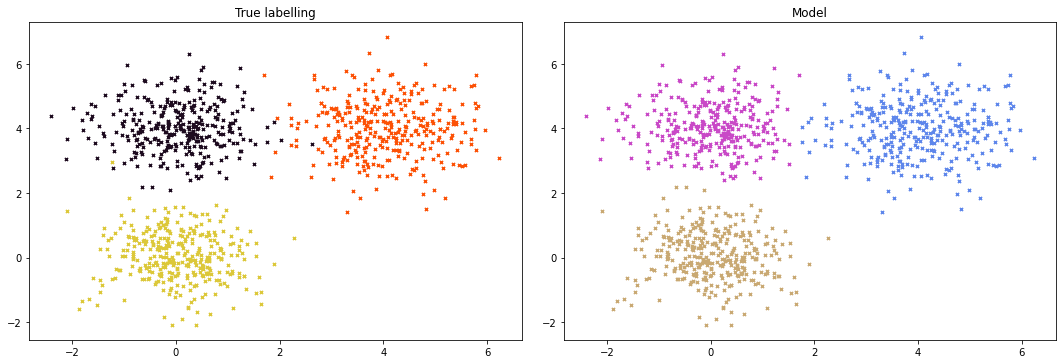

In [14]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
f.tight_layout()

# Recuperamos el modelo que corresponde al mejor resultado
optimal_model = clustering_models_by_n[optimal_n_clusters][[0] == optimal_algorithm_name][1]
optimal_labels = optimal_model.labels_
distinct_labels = list(set(y))

for label in distinct_labels:
    # Etiquetas reales
    axs[0].scatter(X[y == label, 0], X[y == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
    axs[0].set_title("True labelling")

    # Etiquetas provenientes del modelo
    axs[1].scatter(X[optimal_labels == label, 0], X[optimal_labels == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
    axs[1].set_title("Model")

**v) find the contingency table for the best algorithm and number of clusters**

In [15]:
contingency_matrix(y, optimal_labels)

array([[  0,   1, 333],
       [  5, 325,   3],
       [332,   1,   0]])

**vi) determine the asignment of classes to clusters and the number of clustering errors that result from the
best algorithm and number of clusters.**

El resultado es idéntico al mismo ejercicio del apartado a)

**To finish, using one or two paragraphs, comment on whatever you consider adequate regarding the results
obtained, e.g. a certain score is not indicating the real number of clusters and why, whether the mistakes are
relevant or can be accepted, what should be discarded to get an acceptable result, etc**

Ambos índices coinciden en que la solución más óptima es usar el algoritmo Average Linkage, usando 3 clusters, a pesar de que se fijan en cosas distintas (v-measure en homogeneidad y completitud, mientras que dbouldin en lo compactos y separados entre si que son los clusters). Esto da más seguridad a la hora de escoger la solución final. Además, el número de clusters resultante coincide con el número de clases reales encontradas, lo que da más firmeza a la correctitud de la solución.

Como hemos visto, tenemos una completitud de 0.9484 y una homogeneidad de 0.9483. Es un porcentaje de acierto muy bueno, pero solo sería útil para aplicaciones con cierta tolerancia a fallos. No hay ninguna clase contenida al 100% en un cluster ni ningún cluster que contenga el 100% de elementos de una única clase. 

**P6. Repeat problem P5 (except points a.iv and b.iv) using the digits dataset directly available from scikit5
considering each group the following combinations of classes:**